# Lista 4

Alunos: <br>
Eduardo Brasil Araujo <br>
Renalvo Alves Ferreira Júnior

# Questão 1

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def conv(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

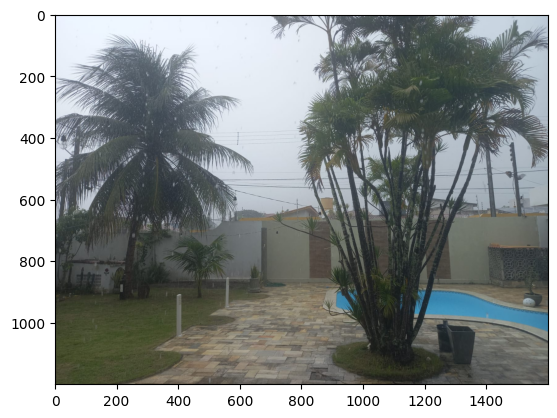

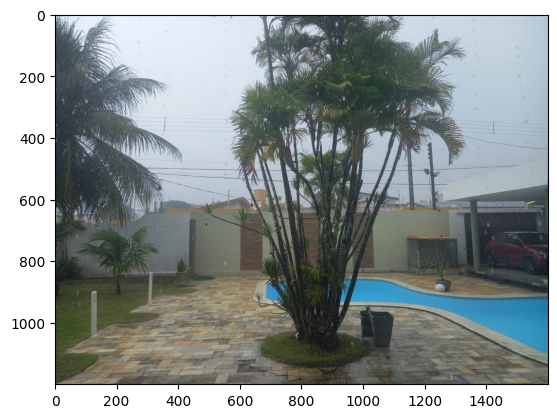

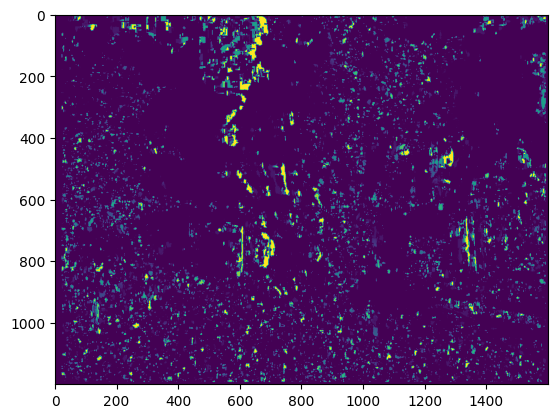

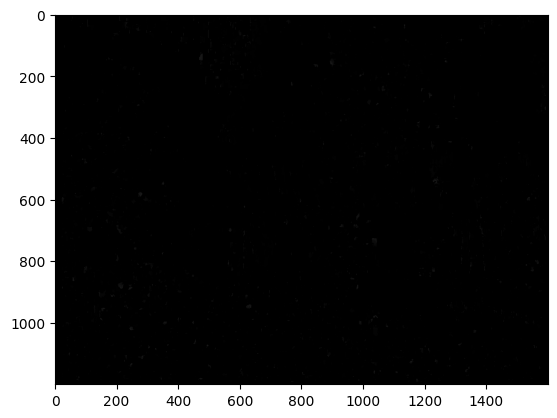

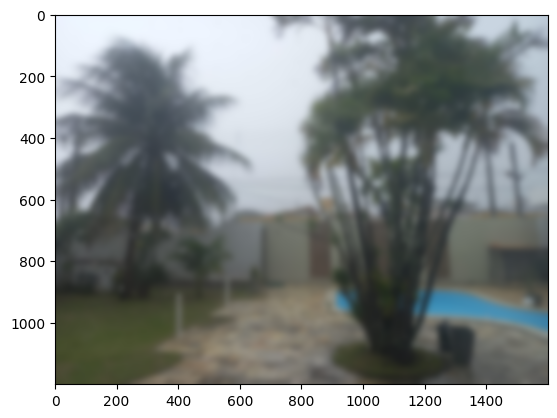

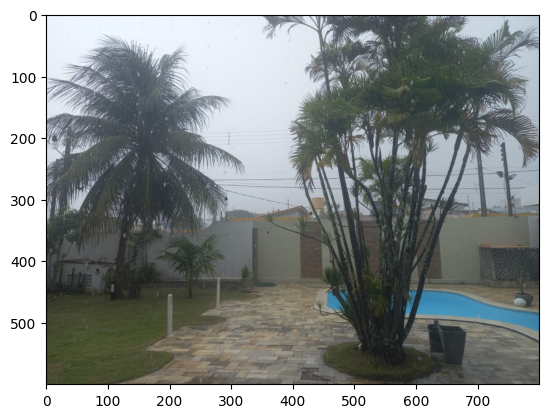

In [11]:
left_image = cv2.imread("images\cas1.jpeg")
right_image = cv2.imread("images\cas2.jpeg")
plt.imshow(conv(left_image))
plt.show()

plt.imshow(conv(right_image))
plt.show()

# Compute disparity map
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(cv2.cvtColor(left_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(right_image, cv2.COLOR_BGR2GRAY))
plt.imshow(disparity)
plt.show()

# Convert disparity map to depth map
depth_map = np.zeros_like(disparity, dtype=np.float32)
depth_map[disparity > 0] = 1.0 / disparity[disparity > 0]
plt.imshow(conv(depth_map))
plt.show()

# Segment foreground and background
foreground_threshold = 0.5
foreground_mask = depth_map < foreground_threshold


# Gaussian blur to the background
background = cv2.GaussianBlur(left_image, (55, 55), sigmaX=10)
plt.imshow(conv(background))
plt.show()

# Combine foreground and background
result = np.where(foreground_mask[..., np.newaxis], left_image, background)

resized_result = cv2.resize(result, (0, 0), fx=0.5, fy=0.5)

plt.imshow(cv2.cvtColor(resized_result, cv2.COLOR_BGR2RGB))
plt.show()

# Questão 2

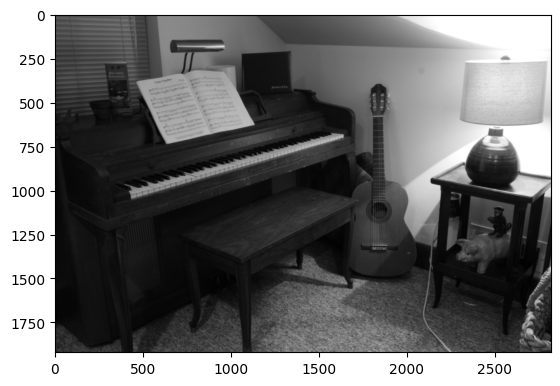

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

data_folder_left = "datasets/q2-dataset/image2/"
data_folder_right = "datasets/q2-dataset/image3/"
data_folder_calib = "datasets/q2-dataset/calib/"
# cat = ['uu', 'uum', 'um']
cat = ['uu', 'uum', 'um', 'calib0', 'calib1']
IDX_LEN = 6

# idx_num = 1
# cat_idx = 2
idx_num = 0  # Index of the new image
cat_idx = 3  # Index of the new "um" file
# fname = cat[cat_idx]+'_'+str(idx_num).zfill(IDX_LEN)
# img_fname = fname + '.png'
# calib_fname = fname + '.txt'
fname = cat[cat_idx]+'_'+str(idx_num).zfill(IDX_LEN)
img_fname = 'im' + str(idx_num) + '.png'
calib_fname = 'calib' + str(idx_num) + '.txt'

img_left_color = cv2.imread(data_folder_left + img_fname)
img_right_color = cv2.imread(data_folder_right + img_fname)

img_left_bw = cv2.blur(cv2.cvtColor(img_left_color, cv2.COLOR_RGB2GRAY),(5,5))
img_right_bw = cv2.blur(cv2.cvtColor(img_right_color, cv2.COLOR_RGB2GRAY),(5,5))

def showImg(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    
def write_ply(fn, verts, colors):
    ply_header = '''ply
    format ascii 1.0
    element vertex %(vert_num)d
    property float x
    property float y
    property float z
    property uchar red
    property uchar green
    property uchar blue
    end_header
    '''
    out_colors = colors.copy()
    verts = verts.reshape(-1, 3)
    verts = np.hstack([verts, out_colors])
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')

plt.imshow(img_right_bw, cmap='gray')

In [ ]:
stereo = cv2.StereoBM_create(numDisparities=96, blockSize=11)
disparity = stereo.compute(img_left_bw,img_right_bw)

img = disparity.copy()
plt.imshow(img, 'CMRmap_r')

In [ ]:
# Reading calibration
matrix_type_1 = 'P2'
matrix_type_2 = 'P3'

calib_file = data_folder_calib + calib_fname
with open(calib_file, 'r') as f:
    fin = f.readlines()
    for line in fin:
        if line[:2] == matrix_type_1:
            calib_matrix_1 = np.array(line[4:].strip().split(" ")).astype('float32').reshape(3,-1)
        elif line[:2] == matrix_type_2:
            calib_matrix_2 = np.array(line[4:].strip().split(" ")).astype('float32').reshape(3,-1)
            
# Calculate depth-to-disparity
cam1 = calib_matrix_1[:,:3] # left image - P2
cam2 = calib_matrix_2[:,:3] # right image - P3

Tmat = np.array([0.54, 0., 0.])

rev_proj_matrix = np.zeros((4,4))

cv2.stereoRectify(cameraMatrix1 = cam1,cameraMatrix2 = cam2, \
                  distCoeffs1 = 0, distCoeffs2 = 0, \
                  imageSize = img_left_color.shape[:2], \
                  R = np.identity(3), T = Tmat, \
                  R1 = None, R2 = None, \
                  P1 =  None, P2 =  None, Q = rev_proj_matrix);

points = cv2.reprojectImageTo3D(img, rev_proj_matrix)

#reflect on x axis
reflect_matrix = np.identity(3)
reflect_matrix[0] *= -1
points = np.matmul(points,reflect_matrix)

#extract colors from image
colors = cv2.cvtColor(img_left_color, cv2.COLOR_BGR2RGB)

#filter by min disparity
mask = img > img.min()
out_points = points[mask]
out_colors = colors[mask]

#filter by dimension
idx = np.fabs(out_points[:,0]) < 4.5
out_points = out_points[idx]
out_colors = out_colors.reshape(-1, 3)
out_colors = out_colors[idx]

write_ply('out.ply', out_points, out_colors)
print('%s saved' % 'out.ply')

# Questão 3

In [60]:
import cv2
import os
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn import svm
import numpy as np

In [43]:
# dataset = datasets.load_files('./datasets/q4-dataset/DogsCats')
class SampleData:
    def __init__(self):
        self.data = []
        self.target = []
    
    def convert(self):
        self.data = np.array(self.data)
        self.target = np.array(self.target)

dataset = SampleData()

def get_images(input_dict, image_path, label):
    for file in os.listdir(image_path):
        input_dict.data.append(np.array(cv2.imread(os.path.join(image_path, file))))
        input_dict.target.append(label)

get_images(dataset, './datasets/q4-dataset/DogsCats/Cats/', 0)
get_images(dataset, './datasets/q4-dataset/DogsCats/Dogs/', 1)

dataset.convert()

In [44]:
X = np.array(dataset.data)
y = np.array(dataset.target)

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.3, random_state=42)

In [67]:
X_train.shape

(75, 256, 256, 3)

## Letter A

In [46]:
X_hog_train, X_hog_test = X_train.copy(), X_test.copy()

In [47]:
hog = cv2.HOGDescriptor()

def convert_hog(input_list):
    global hog
    ret_list = []
    for image in input_list:
        ret_list.append(hog.compute(image))
    return ret_list
        
X_hog_train = convert_hog(X_hog_train)
X_hog_test = convert_hog(X_hog_test)

In [50]:
classifier = svm.SVC()
classifier.fit(X_hog_train, y_train)

SVC()

In [52]:
result = classifier.predict(X_hog_test)

In [63]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [61]:
accuracy = accuracy_score(y_test, result)
cmatrix = confusion_matrix(y_test, result)

Acurácia de 100.0 %


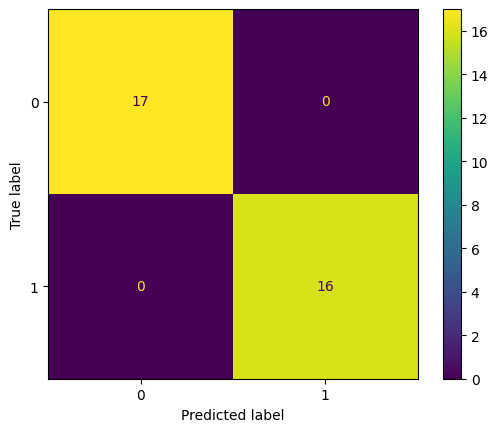

In [64]:
print(f'Acurácia de {accuracy * 100} %')
disp = ConfusionMatrixDisplay(confusion_matrix=cmatrix, display_labels=[0,1])
disp.plot()
plt.show()

## Letter B

In [89]:
import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras.layers import Dense, Flatten

In [66]:
input_shape = (244, 244, 3)

In [78]:
vgg16_input_train = X_train.copy()
vgg16_input_test = X_test.copy()

def to_convert_vgg16(input_list, out_shape):
    ret_list = []
    for image in input_list:
        ret = cv2.resize(image, dsize=out_shape[:2])
        ret_list.append(ret)
    return np.array(ret_list)

vgg16_input_train = to_convert_vgg16(vgg16_input_train, input_shape)
vgg16_input_test = to_convert_vgg16(vgg16_input_test, input_shape)

In [70]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

58889256/58889256 [==============================] - 6s 0us/step


In [71]:
for layer in vgg16.layers:
    layer.trainable = False

In [86]:
vgg16_model = tf.keras.models.Sequential([
    vgg16,
    Flatten(),
    Dense(1, activation='sigmoid')
])

In [87]:
vgg16_model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [88]:
vgg16_history = vgg16_model.fit(vgg16_input_train,
                    y_train,
                    epochs=3,
                    validation_data=(vgg16_input_test, y_test))

Epoch 1/3
3/3 [==============================] - 19s 7s/step - loss: 8.6705 - accuracy: 0.6267 - val_loss: 3.2336e-20 - val_accuracy: 1.0000
Epoch 2/3
3/3 [==============================] - 20s 7s/step - loss: 7.1345e-28 - accuracy: 1.0000 - val_loss: 1.4120e-29 - val_accuracy: 1.0000
Epoch 3/3
3/3 [==============================] - 20s 7s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 9.9333e-36 - val_accuracy: 1.0000


In [90]:
resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

9406464/9406464 [==============================] - 1s 0us/step


In [92]:
for layer in resnet50.layers:
    layer.trainable = False

for layer in mobilenetv2.layers:
    layer.trainable = False

In [93]:
resnet50_model = tf.keras.models.Sequential([
    resnet50,
    Flatten(),
    Dense(1, activation='sigmoid')
])

mobilenetv2_model = tf.keras.models.Sequential([
    mobilenetv2,
    Flatten(),
    Dense(1, activation='sigmoid')
])

In [94]:
resnet50_model.compile(loss='binary_crossentropy',
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=['accuracy'])

mobilenetv2_model.compile(loss='binary_crossentropy',
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=['accuracy'])

In [95]:
resnet50_history = resnet50_model.fit(vgg16_input_train,
                                      y_train,
                                      epochs=3,
                                      validation_data=(vgg16_input_test, y_test))

mobilenetv2_history = mobilenetv2_model.fit(vgg16_input_train,
                                            y_train,
                                            epochs=3,
                                            validation_data=(vgg16_input_test, y_test))

Epoch 1/3
3/3 [==============================] - 13s 4s/step - loss: 0.4894 - accuracy: 0.8133 - val_loss: 5.3276e-08 - val_accuracy: 1.0000
Epoch 2/3
3/3 [==============================] - 8s 3s/step - loss: 2.8425e-08 - accuracy: 1.0000 - val_loss: 3.1644e-12 - val_accuracy: 1.0000
Epoch 3/3
3/3 [==============================] - 8s 3s/step - loss: 5.7487e-13 - accuracy: 1.0000 - val_loss: 5.2568e-15 - val_accuracy: 1.0000
Epoch 1/3
3/3 [==============================] - 6s 1s/step - loss: 0.4604 - accuracy: 0.7467 - val_loss: 0.7564 - val_accuracy: 0.7273
Epoch 2/3
3/3 [==============================] - 2s 878ms/step - loss: 0.3179 - accuracy: 0.9067 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 3/3
3/3 [==============================] - 2s 876ms/step - loss: 2.7129e-04 - accuracy: 1.0000 - val_loss: 0.1859 - val_accuracy: 0.9697


In [102]:
def get_acc_cm(model, name):
    print(f'Resultados para o modelo {name}')
    global vgg16_input_test, y_test
    result = np.array(model.predict(vgg16_input_test))
    result[result > 0.5] = 1
    result[result <= 0.5] = 0
    
    accuracy = accuracy_score(y_test, result)
    cmatrix = confusion_matrix(y_test, result)

    print(f'Acurácia de {accuracy * 100} %')
    disp = ConfusionMatrixDisplay(confusion_matrix=cmatrix, display_labels=[0,1])
    disp.plot()
    plt.show()

Resultados para o modelo VGG16
2/2 [==============================] - 5s 171ms/step
Acurácia de 100.0 %


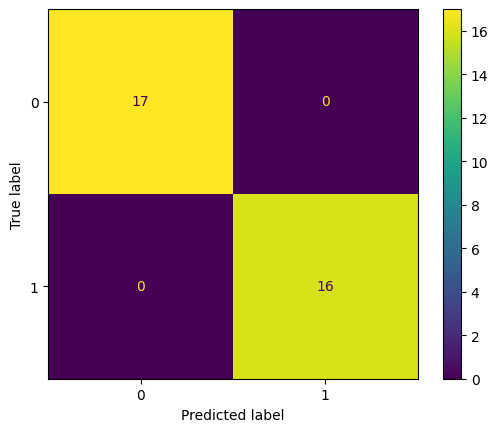

Resultados para o modelo ResNet50
2/2 [==============================] - 3s 116ms/step
Acurácia de 100.0 %


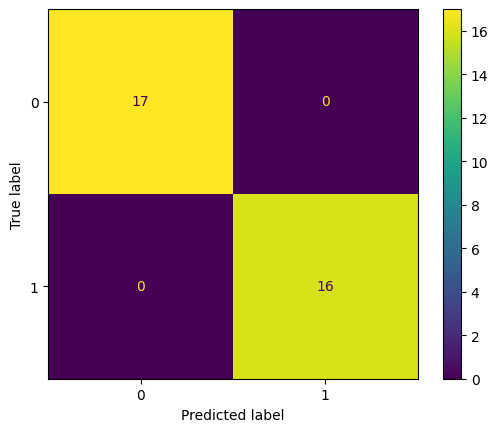

Resultados para o modelo MobileNetV2
2/2 [==============================] - 1s 32ms/step
Acurácia de 96.96969696969697 %


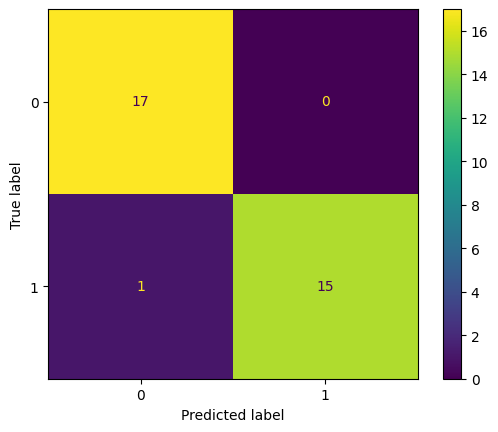

In [103]:
get_acc_cm(vgg16_model, 'VGG16')
get_acc_cm(resnet50_model, 'ResNet50')
get_acc_cm(mobilenetv2_model, 'MobileNetV2')

Mostrando exemplo de classificação do modelo VGG16
1/1 [==============================] - 0s 232ms/step
O resultado foi correto


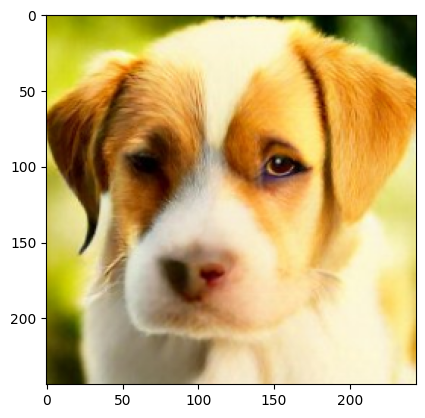

Mostrando exemplo de classificação do modelo ResNet50
1/1 [==============================] - 0s 284ms/step
O resultado foi correto


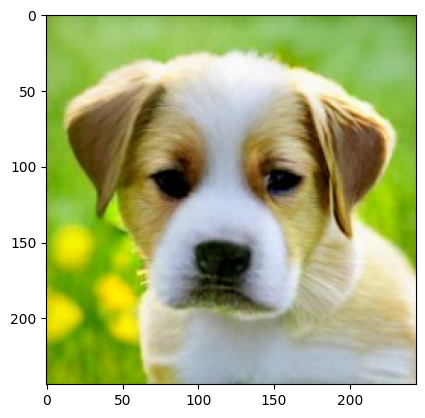

Mostrando exemplo de classificação do modelo MobileNetV2
1/1 [==============================] - 0s 55ms/step
O resultado foi incorreto


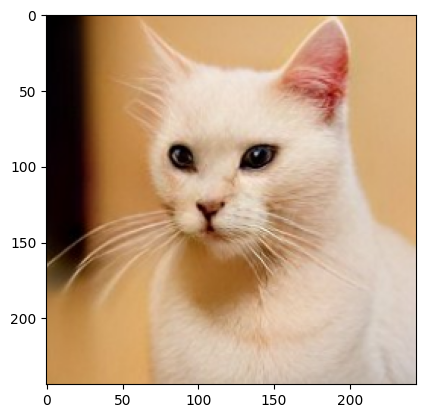

In [114]:
show_examples = []

for image, value in zip(vgg16_input_test, y_test):
    show_examples.append([image, value])

np.random.seed(42)
np.random.shuffle(show_examples)

models_list = [[vgg16_model, 'VGG16'],
               [resnet50_model, 'ResNet50'],
               [mobilenetv2_model, 'MobileNetV2']]

for (image, value), (model, name) in zip(show_examples[:3], models_list):
    print(f'Mostrando exemplo de classificação do modelo {name}')
    prediction = model.predict(np.array([image]))
    print(f'O resultado foi {"correto" if prediction == value else "incorreto"}')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

# Questão 4

## Letter A

A principal diferença entre o modelo SSD e o YOLO v5 é que o primeiro oferece *bounding boxes* mais precisos, isto devido à arquitetura em que consiste em mudar o modelo da convolução para cada camada de características (*features*), diferentemente da segunda, que é contraindicado para detecção de objetos ou coisas pequenas (tipo pássaros), porém, contudo, é bastante indicado para aplicações em tempo real, por apresentar uma performance bem superior à anterior. 

## Letter B

In [2]:
import cv2
import torch
import torchvision
import numpy as np

### YOLOv5

In [11]:
yolov5s_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
device = torch.device('cuda')

Using cache found in C:\Users\localhost/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-5-12 Python-3.10.7 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce GTX 1060 6GB, 6144MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [12]:
capture = cv2.VideoCapture('./videos/bridge.mp4')

In [13]:
frame_rate = int(capture.get(cv2.CAP_PROP_FPS))
frame_size = (int(capture.get(cv2.CAP_PROP_FRAME_WIDTH)),
              int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT)))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output = cv2.VideoWriter('./videos/output_YOLOv5s.mp4',
                         apiPreference=cv2.CAP_FFMPEG,
                         fourcc=fourcc,
                         fps=frame_rate,
                         frameSize=frame_size)

In [14]:
model_names = yolov5s_model.names

yolov5s_model_plot = []

while capture.isOpened():
    ret, frame = capture.read()
    if not ret:
        break
    
    # Transforming the frame to work with model
    frame_uploaded = frame

    # Applying the model to the frame
    results = yolov5s_model(frame_uploaded)

    # Getting labels and coordinates of bounds
    labels, coords = results.xyxyn[0][:, -1].cpu().numpy(), results.xyxyn[0][:, :-1].cpu().numpy()

    # Drawing bounding boxes
    count = 0
    for label, coord in zip(labels, coords):
        if model_names[label] == 'car':
            x1, y1, x2, y2, confidence = coord
            cv2.rectangle(frame,
                        (int(x1 * frame_size[0]), int(y1 * frame_size[1])),
                        (int(x2 * frame_size[0]), int(y2 * frame_size[1])),
                        (0, 255, 0), 2)
            count += 1
    
    yolov5s_model_plot.append(count)

    # Write the frame with the drawn bounding boxes to the output video
    output.write(frame)

capture.release()
output.release()

### SSD

In [ ]:
ssd_model = torchvision.models.detection.ssd300_vgg16(pretrained=True)
ssd_model.to(device)
ssd_model.eval()

In [18]:
def detect_objects(image, threshold=0.5):
    global ssd_model
    # Convert image to tensor
    image = image.transpose((2, 0, 1)).copy().astype(np.float64) / 255
    image_tensor = torch.from_numpy(image).float()
    image_tensor = image_tensor.unsqueeze(0).to(device)

    # Perform object detection
    with torch.no_grad():
        output = ssd_model(image_tensor)
        boxes = output[0]['boxes'].cpu().numpy()
        scores = output[0]['scores'].cpu().numpy()
        labels = output[0]['labels'].cpu().numpy()

    # Filter detections based on score threshold
    mask = scores > threshold
    boxes = boxes[mask]
    scores = scores[mask]
    labels = labels[mask]

    return boxes, scores, labels

In [19]:
capture = cv2.VideoCapture('./videos/bridge.mp4')

In [20]:
frame_rate = int(capture.get(cv2.CAP_PROP_FPS))
frame_size = (int(capture.get(cv2.CAP_PROP_FRAME_WIDTH)),
              int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT)))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output = cv2.VideoWriter('./videos/output_SSD.mp4',
                         apiPreference=cv2.CAP_FFMPEG,
                         fourcc=fourcc,
                         fps=frame_rate,
                         frameSize=frame_size)

In [21]:
ssd_model_plot = []

while capture.isOpened():
    ret, frame = capture.read()
    if not ret:
        break
    
    # Transforming the frame to work with model
    frame_uploaded = frame[:,:,::-1]

    # Applying the model to the frame
    boxes, scores, labels = detect_objects(frame_uploaded)
    
    count = 0
    # Drawing bounding boxes
    for box, score, label in zip(boxes, scores, labels):
        if label == 3:
            cv2.rectangle(frame,
                          (int(box[0]), int(box[1])),
                          (int(box[2]), int(box[3])),
                          (0, 255, 0), 2)
            count += 1

    ssd_model_plot.append(count)

    # Write the frame with the drawn bounding boxes to the output video
    output.write(frame)

capture.release()
output.release()

## Letter C

In [22]:
import matplotlib.pyplot as plt

%matplotlib inline

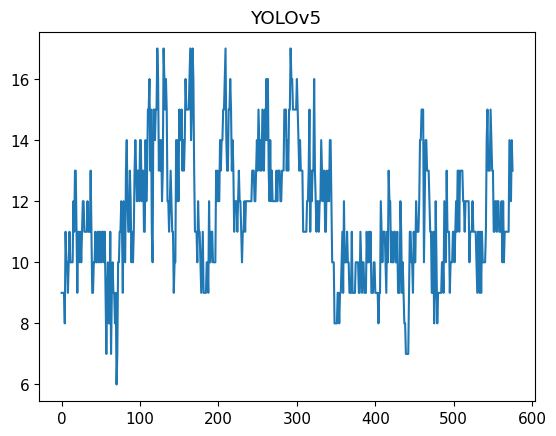

In [24]:
plt.plot(np.arange(len(yolov5s_model_plot)), yolov5s_model_plot)
plt.title('YOLOv5')
plt.show()

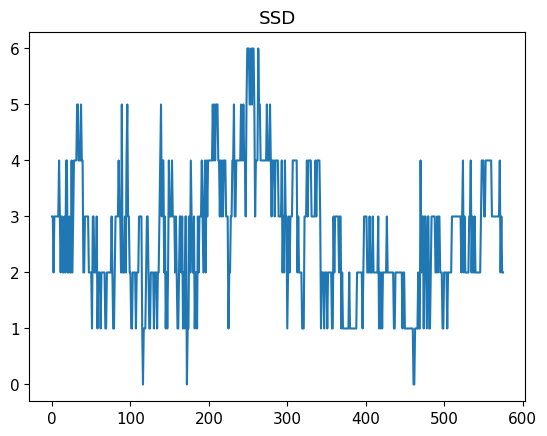

In [25]:
plt.plot(np.arange(len(ssd_model_plot)), ssd_model_plot)
plt.title('SSD')
plt.show()